In [284]:
import numpy as np
import cv2
import math
from PIL import Image, ImageStat
import sys
from os import listdir

In [285]:
def get_image(image_path):
    """
    Get a numpy 2D array of an image so that one can access RGBA[x][y] or RGBA[x,y].
    
    Also get a cropped image for further use for hsv and k-means clustering
    
    """
    image = Image.open(image_path, 'r')
    width, height = image.size
    area = (0, 0, width, 0.5*height)
    image = image.crop(area) # crop top half of the image
#     result = Image.fromarray(image.astype(np.uint8))
    image.save("cropped.png")
    width, height = image.size
#     print (image.size)
    pixel_values = list(image.getdata())
    if image.mode == 'RGBA':
        channels = 4
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
#     pixel_values = np.array(pixel_values).reshape((width, height, channels))
    pixel_values = np.array(pixel_values).reshape((height, width, channels))
#     print (np.shape(pixel_values))

    return pixel_values,image #return pixels matrix with RGBA value, and cropped half image

In [286]:
def get_bri(pixels):
    """
    Get a numpy 2D array of an image so that one can access brightness[x][y]
       
    """
    brightness=[[0 for x in range(len(pixels[0]))] for y in range(len(pixels))]
    # Matrix = [[0 for x in range(w)] for y in range(h)]
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            R,G,B,A=pixels[i,j]
            brightness[i][j]=0.2126*R + 0.7152*G + 0.0722*B
    return brightness

In [287]:
def hsv( image ):
    """
    Get a numpy 2D array of an image so that one can access HSV[x][y]
       
    """
    img = np.array(image)
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     H,S,V=cv2.split(HSV)
    #H = HSV[:,:,0]
    #S = HSV[:,:,1].mean
    #V = HSV[:,:,2].mean
    #return H,S,V
#     H=np.mean(H)
#     S=np.mean(S)
#     V=np.mean(V)
    return HSV

In [288]:
def hls(image):
    img = np.array(image)
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return HLS

In [289]:
"""
Load and feature extraction and calculation
"""

path1 = "/Users/caijieyang/Desktop/experiment"
files= listdir(path1)
for file in files:
    if "panorama" in file:
        pixels,image=get_image(file)
        print (np.shape(pixels))
            # print (pixel1)
        brightness=get_bri(pixels)
        HSV=hsv(image)
        HLS=hls(image)
        print (np.shape(HSV))
        print (np.shape(HLS))

(106, 425, 4)
(106, 425, 3)
(106, 425, 3)


In [290]:
# print (pixels[100,200])
print (HLS[0,:])

[[104 165  30]
 [105 164  28]
 [106 165  30]
 ...
 [106 165  31]
 [106 165  31]
 [106 165  31]]


In [291]:
"""
convert brightness into array
"""

print (np.shape(pixels))
print (np.shape(image))

brightness=np.asarray(brightness)
# brightness=brightness.transpose()
# print (np.shape(brightness))
# print ("pixel RGBA: ", pixels[0,0])
# print ("cloud brightness:", brightness[0][0])
# print ("cloud RGBA:", pixels[0,0])
# print ("sky brightness:", brightness[94][462])
# print ("sky RGBA:", pixels[94,462])
# print ("tree brightness:", brightness[140][127])
# print ("tree RGBA:", pixels[140,127])

(106, 425, 4)
(106, 425, 4)


In [292]:
"""
K-means clustering to segment the image into 12 color class 

clustered.png is used as output

"""


file=("cropped.png")


img = cv2.imread(file)
Z = img.reshape((-1,3))#reshape array into n rows and 3 colunms

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10 #number of clusters
ret,label,center=cv2.kmeans(Z,K,None,criteria,50,cv2.KMEANS_PP_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
label2=label.reshape((len(img),len(img[0]))) #save the label into 2D array corresponde to image shape
res2 = res.reshape((img.shape))
result = Image.fromarray(res2.astype(np.uint8))
result.save("clustered.png")
# cv2.imshow('res2',res2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [293]:
# grayimg = np.array(img)
grayimg=cv2.imread(file)
graypix = cv2.cvtColor(grayimg, cv2.COLOR_RGB2GRAY)

# graypix=cvtColor(img,COLOR_RGB2GRAY)
cv2.imwrite('gray_image.png',graypix)


True

In [294]:
print (np.shape(res2))
print (np.shape(label2))
print (label2[:,0])

(106, 425, 3)
(106, 425)
[0 0 0 0 0 0 0 0 0 8 0 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 2 2 8 8 2 2
 2 2 2 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 2 2 2 9 9 9 9 2 2 2 2
 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 2 2 8 8 8 8 8]


(106, 425)


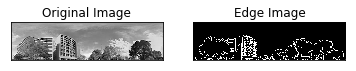

In [302]:
from matplotlib import pyplot as plt
img = cv2.imread('cropped.png',0)
edges = cv2.Canny(img,150,500)
result = Image.fromarray(edges.astype(np.uint8))
result.save("edged100550.png")
print (np.shape(edges))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([]) 
plt.show()

In [303]:
# for i in range(len(edges)):
#     for j in range(len(edges[i])):
counter = 0
for i in edges:
    for j in i:
        if j == 255:
            counter+=1
sum=len(edges)*len(edges[0])
print (counter/sum)

0.08552719200887902


In [297]:
#get B max in image
Bmax=0
for i in pixels:
#     print (i)
    for j in i:
        if j[2]>Bmax:
            Bmax=j[2]
            
print (Bmax)
print (HLS[100])

255
[[ 37 190  16]
 [ 36 197  11]
 [ 90 200   5]
 ...
 [ 46 201  30]
 [ 37 180  22]
 [ 34 183  25]]


In [298]:
#HLS [0]:H [1]:S [2]:L
counterclass_skypre={}
counterclass_all={}
Skypre=[[0 for x in range(len(pixels[0]))] for y in range(len(pixels))]
for i in range(len(label2)):
    for j in range(len(label2[0])):
        if label2[i][j] not in counterclass_all:
            counterclass_all[label2[i][j]]=1
        else:            
            counterclass_all[label2[i][j]]+=1
#         if label2[i][j]==0:
        #add condition like white cloud as sky
        if HLS[i][j][0]>=0.35*180 or HLS[i][j][2]>=0.95*255 \
            or (HLS[i][j][1]<=0.005*255 and pixels[i][j][2]>=0.9*Bmax) \
            or (HLS[i][j][1]>=0.03*255 and pixels[i][j][2]>=0.9*Bmax) or \
            ((pixels[i][j][2]>=0.95*Bmax) and ((abs(pixels[i][j][2]-pixels[i][j][0])<0.02*255))):
            Skypre[i][j]=1
            if label2[i][j] not in counterclass_skypre:
                counterclass_skypre[label2[i][j]]=1
            else:
                counterclass_skypre[label2[i][j]]+=1
# print (np.shape(Skypre))            
# print (counter)
# print (counterclass_skypre)


        
            

In [299]:
skylabel_list=[]
for i in counterclass_skypre:
    if counterclass_skypre[i]/counterclass_all[i]>0.6:
        skylabel_list.append(i)
print (skylabel_list)

[0, 8, 7, 6, 2, 9]


In [300]:
RED = 0
GREEN = 1
BLUE = 2

data = np.asarray(image,dtype="int32")
print (np.shape(data))
for i in range(len(brightness)):
    for j in range(len(brightness[0])):
        if label2[i][j] in skylabel_list:
            data[i, j, GREEN] = 0
            data[i, j, RED] = 0
            data[i, j, BLUE] = 255
        else:
            continue
result = Image.fromarray(data.astype(np.uint8))
result.save("sky_mark.png")

(106, 425, 4)


In [301]:
RED = 0
GREEN = 1
BLUE = 2

data = np.asarray(image,dtype="int32")
print (np.shape(data))
for i in range(len(brightness)):
    for j in range(len(brightness[0])):
        if 100<pixels[i][j][1]<255 and pixels[i][j][0]>100 and pixels[i][j][2]>100:
            data[i, j, GREEN] = 0
            data[i, j, RED] = 0
            data[i, j, BLUE] = 255
        else:
            continue
result = Image.fromarray(data.astype(np.uint8))
result.save("sky_mark1.png")

(106, 425, 4)
